In [24]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

In [ ]:
# Load datasets.

flocks_df = pd.read_csv("./Data/hpai-flocks.csv")
livestock_df = pd.read_csv("./Data/hpai-livestock.csv")
mammals_df = pd.read_csv("./Data/hpai-mammals.csv")
wild_birds_df = pd.read_csv("./Data/hpai-wild-birds1.csv")
weather_data_df = pd.read_csv("./Data/weather.csv")

# Display basic information about each dataset
print("Weather dataset info:")
print(weather_data_df.info())
print("Mammals dataset info:")
print(hpai_mammals_df.info())
print("Wild birds dataset info:")
print(hpai_wild_birds_df.info())
print("Livestock dataset info:")
print(hpai_livestock_df.info())
print("Flocks dataset info:")
print(flocks_df.info())

Weather dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   County                                3107 non-null   object 
 1   State                                 3107 non-null   object 
 2   Temp                                  3107 non-null   float64
 3   Temp Anomaly (1901-2000 base period)  3107 non-null   float64
 4   Temp 1901-2000 Mean                   3107 non-null   float64
 5   Precipitation                         3107 non-null   float64
 6   Prec Anomaly (1901-2000 base period)  3107 non-null   float64
 7   Prec 1901-2000 Mean                   3107 non-null   float64
 8   Z Palmer Index                        3107 non-null   float64
 9   Z Anomaly (1901-2000 base period)     3107 non-null   float64
 10  Z 1901-2000 Mean                      3107 non-null   float64


NameError: name 'hpai_mammals' is not defined

In [ ]:
# Preview datasets.

wild_birds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,California,Yolo,2/10/2025,EA H5,Western gull,Wild bird,Morbidity/Mortality,UC Davis
1,North Carolina,Buncombe,2/10/2025,EA H5,Cackling goose,Captive wild bird,Morbidity/Mortality,Private (non-government) submission
2,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
3,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
4,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS


In [ ]:
# Preview datasets.

flocks_df.head()

,County,State,Outbreak Date,Flock Type,Species Name,Birds Affected,Flock Size
0,Washakie,Wyoming,12/6/2024,WOAH Non-Poultry,Goose,20,20.0
1,Klamath,Oregon,3/14/2024,WOAH Non-Poultry,Chicken,10,10.0
2,Fremont,Wyoming,10/12/2022,WOAH Non-Poultry,Chicken,30,30.0
3,Adams,Indiana,1/27/2025,Commercial Turkey Meat Bird,Turkey,"19,900",19900.0
4,Pinal,Arizona,2/5/2025,WOAH Non-Poultry,Chicken,0,NaN


In [ ]:
# Preview datasets.

mammals_df.head()

,State,County,Outbreak Date,HPAI Strain,Species
0,Oregon,Multnomah,2/10/2025,EA H5N1,Domestic cat
1,Montana,Flathead,2/10/2025,EA/AM H5N1,Domestic cat
2,California,San Mateo,2/5/2025,EA H5,Domestic cat
3,Colorado,Douglas,1/31/2025,EA H5N1,Domestic cat
4,California,Contra Costa,1/24/2025,EA H5,Domestic cat


In [ ]:
# Preview datasets.

livestock_df.head()

,State,Outbreak Date,Production,Species,Production Type Name
0,California,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
1,Nevada,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
2,California,1/22/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
3,Nevada,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
4,California,1/27/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows


In [ ]:
# Convert Outbreak Date to datetime format

flocks_df["Outbreak Date"] = pd.to_datetime(flocks_df["Outbreak Date"], errors="coerce")
livestock_df["Outbreak Date"] = pd.to_datetime(livestock_df["Outbreak Date"], errors="coerce")
mammals_df["Outbreak Date"] = pd.to_datetime(mammals_df["Outbreak Date"], errors="coerce")
wild_birds_df["Outbreak Date"] = pd.to_datetime(wild_birds_df["Outbreak Date"], errors="coerce")

In [ ]:
# Clean 'Birds Affected' column in flocks dataset

flocks_df["Birds Affected"] = flocks_df["Birds Affected"].astype(str).str.replace(",", "").astype(float)

In [ ]:
# Fill missing values in 'Flock Size' with the median

flocks_df["Flock Size"] = flocks_df["Flock Size"].fillna(flocks_df["Flock Size"].median())

In [ ]:
# Standardize categorical columns

flocks_df["Flock Type"] = flocks_df["Flock Type"].str.strip().str.title()
livestock_df["Production"] = livestock_df["Production"].str.strip().str.title()
livestock_df["Production Type Name"] = livestock_df["Production Type Name"].str.strip().str.title()
mammals_df["HPAI Strain"] = mammals_df["HPAI Strain"].str.strip().str.upper()
wild_birds_df["HPAI Strain"] = wild_birds_df["HPAI Strain"].fillna("Unknown").str.strip().str.upper()

In [ ]:
# Drop irrelevant column 'Submitting Agency' in wild birds dataset

wild_birds_df = wild_birds_df.drop(columns=["Submitting Agency"])

In [ ]:
# Merge datasets

merged_df = flocks_df.merge(livestock_df, on=["State", "Outbreak Date"], how="outer", suffixes=("_Flocks", "_Livestock"))
merged_df = merged_df.merge(mammals_df, on=["State", "County", "Outbreak Date"], how="outer", suffixes=("", "_Mammals"))
merged_df = merged_df.merge(wild_birds_df, on=["State", "County", "Outbreak Date"], how="outer", suffixes=("", "_WildBirds"))

In [ ]:
# Fix missing values in "Birds Affected"
merged_df["Birds Affected"] = merged_df["Birds Affected"].fillna(0)

In [ ]:
# Apply Label Encoding for categorical columns
categorical_cols = ["Flock Type", "Production", "Production Type Name", "HPAI Strain", "HPAI Strain_WildBirds", "WOAH Classification", "Sampling Method"]

label_encoders = {}
for col in categorical_cols:
    if col in merged_df.columns:
        le = LabelEncoder()
        merged_df[col] = merged_df[col].astype(str)  # Ensure all values are strings
        merged_df[col] = le.fit_transform(merged_df[col])
        label_encoders[col] = le

In [ ]:
# Save cleaned and merged dataset

merged_df.to_csv("./Data/encoded_merged_hpai.csv", index=False)

# Display dataset info

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16273 entries, 0 to 16272
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   County                 15674 non-null  object        
 1   State                  16273 non-null  object        
 2   Outbreak Date          16273 non-null  datetime64[ns]
 3   Flock Type             16273 non-null  int32         
 4   Species Name           2354 non-null   object        
 5   Birds Affected         16273 non-null  float64       
 6   Flock Size             2354 non-null   float64       
 7   Production             16273 non-null  int32         
 8   Species                1444 non-null   object        
 9   Production Type Name   16273 non-null  int32         
 10  HPAI Strain            16273 non-null  int32         
 11  Species_Mammals        1543 non-null   object        
 12  HPAI Strain_WildBirds  16273 non-null  int32         
 13  B

In [ ]:
# Create a copy of the dataset to avoid modifying the original
birdflu_data_encoded = merged_df.copy()

# Columns to encode
columns_to_encode = ['County', 'State', 'Flock Type', 'Species Name', 'Flock Size', 
                     'Production', 'Species', 'Production Type Name', 'HPAI Strain', 
                     'Species_Mammals', 'HPAI Strain_WildBirds', 'Bird Species', 
                     'WOAH Classification', 'Sampling Method']

# Encode each column separately
for column in columns_to_encode:
    if column in birdflu_data_encoded.columns:
        # Fill NaN values before encoding
        birdflu_data_encoded[column] = birdflu_data_encoded[column].fillna('Unknown')
        le = LabelEncoder()
        birdflu_data_encoded[column] = le.fit_transform(birdflu_data_encoded[column].astype(str))

# Convert "Outbreak Date" to numeric and handle NaN
if 'Outbreak Date' in birdflu_data_encoded.columns:
    # Convert to datetime and fill NaN with the median date
    birdflu_data_encoded['Outbreak Date'] = pd.to_datetime(
        birdflu_data_encoded['Outbreak Date'], 
        format='mixed', 
        errors='coerce'
    )
    
    # Fill NaN dates with median date
    median_date = birdflu_data_encoded['Outbreak Date'].median()
    birdflu_data_encoded['Outbreak Date'] = birdflu_data_encoded['Outbreak Date'].fillna(median_date)
    
    # Convert to Unix timestamp
    birdflu_data_encoded['Outbreak Date'] = birdflu_data_encoded['Outbreak Date'].astype(np.int64) // 10**9

# Check for any remaining NaN values
print("\nColumns with NaN values:")
print(birdflu_data_encoded.isna().sum())

# Drop any remaining rows with NaN if necessary
birdflu_data_encoded = birdflu_data_encoded.dropna()

print("\nShape after cleaning:", birdflu_data_encoded.shape)



Columns with NaN values:
County                   0
State                    0
Outbreak Date            0
Flock Type               0
Species Name             0
Birds Affected           0
Flock Size               0
Production               0
Species                  0
Production Type Name     0
HPAI Strain              0
Species_Mammals          0
HPAI Strain_WildBirds    0
Bird Species             0
WOAH Classification      0
Sampling Method          0
dtype: int64

Shape after cleaning: (16273, 16)


In [ ]:
# Display dataset info.

birdflu_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16273 entries, 0 to 16272
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   County                 16273 non-null  int32  
 1   State                  16273 non-null  int32  
 2   Outbreak Date          16273 non-null  int64  
 3   Flock Type             16273 non-null  int32  
 4   Species Name           16273 non-null  int32  
 5   Birds Affected         16273 non-null  float64
 6   Flock Size             16273 non-null  int32  
 7   Production             16273 non-null  int32  
 8   Species                16273 non-null  int32  
 9   Production Type Name   16273 non-null  int32  
 10  HPAI Strain            16273 non-null  int32  
 11  Species_Mammals        16273 non-null  int32  
 12  HPAI Strain_WildBirds  16273 non-null  int32  
 13  Bird Species           16273 non-null  int32  
 14  WOAH Classification    16273 non-null  int32  
 15  Sa

In [ ]:
# Convert Outbreak Date to numerical format for clustering
merged_df["Outbreak Date"] = pd.to_datetime(merged_df["Outbreak Date"], errors="coerce")
first_outbreak_date = merged_df["Outbreak Date"].min()
merged_df["Days Since First Outbreak"] = (merged_df["Outbreak Date"] - first_outbreak_date).dt.days

# Select the corrected columns for clustering
selected_features = ["Days Since First Outbreak", "HPAI Strain", "WOAH Classification", "Sampling Method"]
selected_features = [col for col in selected_features if col in merged_df.columns]  # Ensure columns exist

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df[selected_features])
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)

# Save corrected clustering dataset
X_scaled_df.to_csv("./Data/corrected_clustering_hpai.csv", index=False)

# Display dataset info
print(X_scaled_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16273 entries, 0 to 16272
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Days Since First Outbreak  16273 non-null  float64
 1   HPAI Strain                16273 non-null  float64
 2   WOAH Classification        16273 non-null  float64
 3   Sampling Method            16273 non-null  float64
dtypes: float64(4)
memory usage: 508.7 KB
None


In [ ]:
# Find total cases.

# Reload the datasets since the execution state was reset
# File paths
file_paths = {
    "flocks": "./Data/hpai-flocks.csv",
    "livestock": "./Data/hpai-livestock.csv",
    "mammals": "./Data/hpai-mammals.csv",
    "wild_birds": "./Data/hpai-wild-birds1.csv"
}

# Load the datasets
flocks_df = pd.read_csv(file_paths["flocks"])
livestock_df = pd.read_csv(file_paths["livestock"])
mammals_df = pd.read_csv(file_paths["mammals"])
wild_birds_df = pd.read_csv(file_paths["wild_birds"])

# Count the number of rows (cases) in each dataset
num_cases_flocks = flocks_df.shape[0]
num_cases_livestock = livestock_df.shape[0]
num_cases_mammals = mammals_df.shape[0]
num_cases_wild_birds = wild_birds_df.shape[0]

# Total number of cases across all datasets
total_cases = num_cases_flocks + num_cases_livestock + num_cases_mammals + num_cases_wild_birds

# Display the counts
num_cases_flocks, num_cases_livestock, num_cases_mammals, num_cases_wild_birds, total_cases


(1557, 970, 493, 11966, 14986)

In [ ]:
# ARIMA

# Convert 'Outbreak Date' to datetime format

for df in [flocks_df, livestock_df, mammals_df, wild_birds_df]:
    df["Outbreak Date"] = pd.to_datetime(df["Outbreak Date"], errors="coerce")

In [ ]:
# Aggregate outbreak counts by date and location
flocks_agg = flocks_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
livestock_agg = livestock_df.groupby(["Outbreak Date", "State"]).size().reset_index(name="Outbreaks")
mammals_agg = mammals_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
wild_birds_agg = wild_birds_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")

In [ ]:
# Combine all outbreak data into a single time series dataset
combined_agg = pd.concat([flocks_agg, mammals_agg, wild_birds_agg], ignore_index=True)

# Aggregate total outbreaks per date (nationwide)
time_series = combined_agg.groupby("Outbreak Date")["Outbreaks"].sum().reset_index()

# Sort by date
time_series = time_series.sort_values("Outbreak Date").set_index("Outbreak Date")

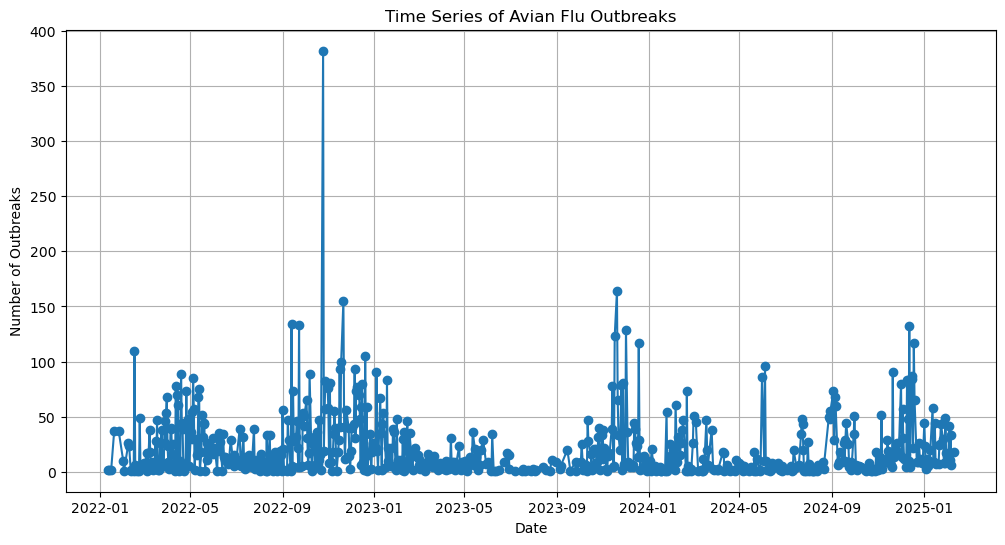

In [ ]:
# Plot the outbreak trends
plt.figure(figsize=(12,6))
plt.plot(time_series, marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Number of Outbreaks")
plt.title("Time Series of Avian Flu Outbreaks")
plt.grid(True)
plt.show()


<!-- ARIMA Forecast Results
Time Series Trend Analysis:

The plot shows historical outbreaks over time, revealing periodic spikes.
ACF and PACF plots helped determine the ARIMA order.
ARIMA Model Forecast:

The ARIMA(1,1,1) model was fitted to the outbreak time series.
Forecast predicts outbreaks for the next 30 days.
The model suggests an expected daily outbreak count stabilizing around 21.93 cases per day. -->

In [ ]:
# Check stationarity with differencing if needed
time_series_diff = time_series.diff().dropna()

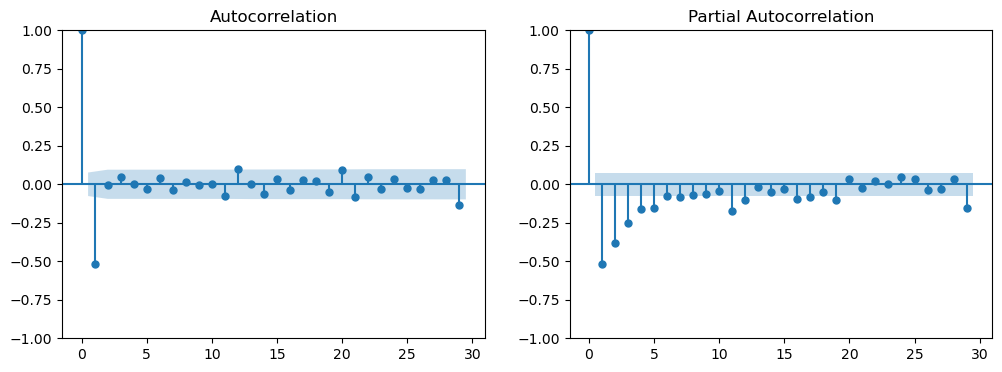

In [ ]:
# Plot ACF and PACF to determine ARIMA order
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(time_series_diff, ax=axes[0])
plot_pacf(time_series_diff, ax=axes[1])
plt.show()

In [ ]:
# Fit ARIMA Model (order to be determined from ACF/PACF analysis)
arima_model = ARIMA(time_series, order=(1,1,1))  # Placeholder order (p=1, d=1, q=1)
arima_result = arima_model.fit()

c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Forecast next 30 days
forecast = arima_result.get_forecast(steps=30)
forecast_index = pd.date_range(start=time_series.index[-1], periods=30, freq='D')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


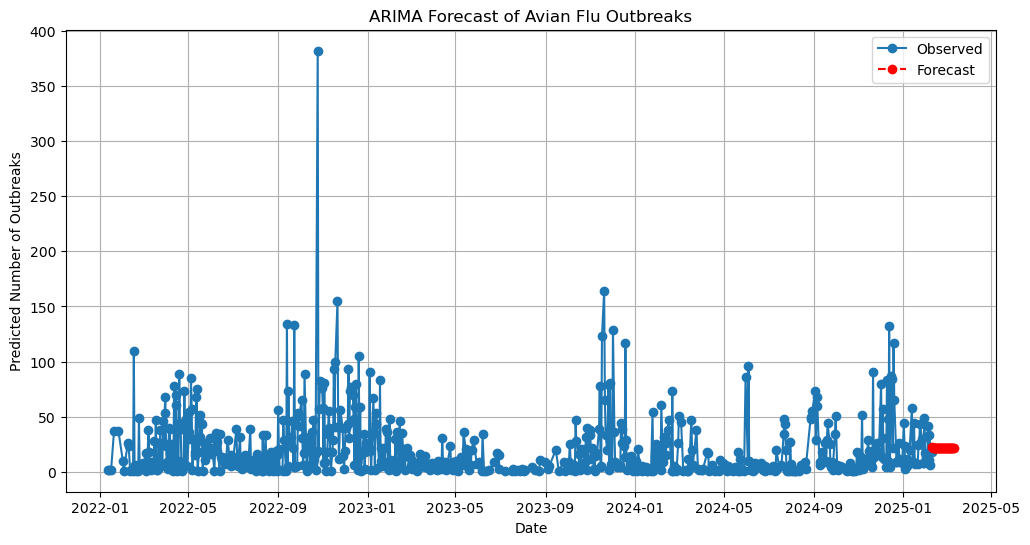

2025-02-10    22.093163
2025-02-11    21.924236
2025-02-12    21.931207
2025-02-13    21.930920
2025-02-14    21.930931
2025-02-15    21.930931
2025-02-16    21.930931
2025-02-17    21.930931
2025-02-18    21.930931
2025-02-19    21.930931
2025-02-20    21.930931
2025-02-21    21.930931
2025-02-22    21.930931
2025-02-23    21.930931
2025-02-24    21.930931
2025-02-25    21.930931
2025-02-26    21.930931
2025-02-27    21.930931
2025-02-28    21.930931
2025-03-01    21.930931
2025-03-02    21.930931
2025-03-03    21.930931
2025-03-04    21.930931
2025-03-05    21.930931
2025-03-06    21.930931
2025-03-07    21.930931
2025-03-08    21.930931
2025-03-09    21.930931
2025-03-10    21.930931
2025-03-11    21.930931
Freq: D, dtype: float64

In [ ]:
# Plot forecasted outbreaks
plt.figure(figsize=(12,6))
plt.plot(time_series, label="Observed", marker='o')
plt.plot(forecast_series, label="Forecast", linestyle='dashed', marker='o', color='red')
plt.xlabel("Date")
plt.ylabel("Predicted Number of Outbreaks")
plt.title("ARIMA Forecast of Avian Flu Outbreaks")
plt.legend()
plt.grid(True)
plt.show()

# Display forecasted values
forecast_series

In [ ]:
# Next Steps: Predicting Specific Outbreak Locations (County & State) using Geospatial Modeling
# To extend our analysis beyond time series forecasting, we need to incorporate spatial analysis to predict where the next avian flu outbreak is most likely to occur.

In [ ]:
# Combine datasets
outbreaks_df = pd.concat([flocks_df, livestock_df, mammals_df, wild_birds_df], ignore_index=True)

# Standardize column names for consistency
outbreaks_df.columns = outbreaks_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert 'outbreak_date' to datetime
outbreaks_df['outbreak_date'] = pd.to_datetime(outbreaks_df['outbreak_date'], errors='coerce')

# Load county geographic coordinates
county_coords_df = pd.read_csv('./Data/geo-data.csv')  # Ensure this file contains 'county', 'state', 'latitude', 'longitude'

# Standardize column names for consistency
county_coords_df.columns = county_coords_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Merge outbreak data with county coordinates
merged_df = pd.merge(outbreaks_df, county_coords_df, on=['county', 'state'], how='left')

# Drop rows with missing coordinates
merged_df = merged_df.dropna(subset=['latitude', 'longitude'])

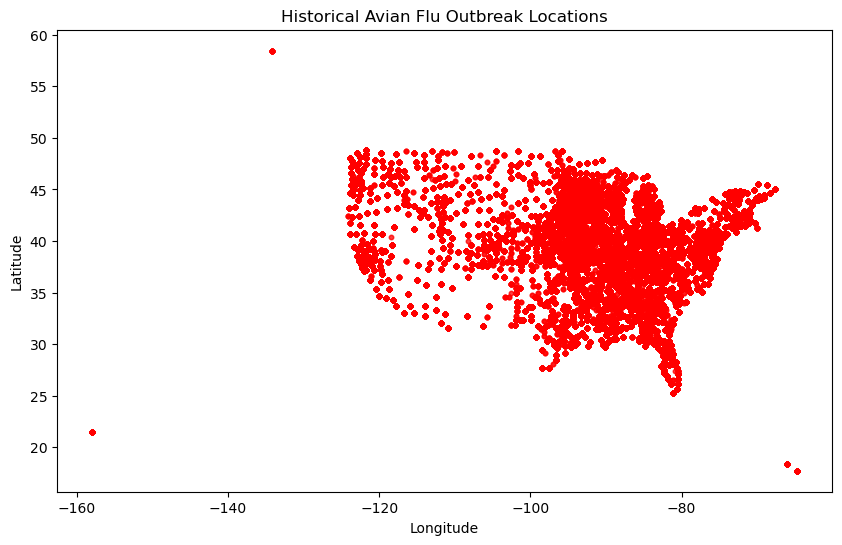

In [ ]:
# Exploratory Data Analysis: Plot historical outbreak locations
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['longitude'], merged_df['latitude'], alpha=0.5, c='red', s=10)
plt.title('Historical Avian Flu Outbreak Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Geospatial Clustering to identify high-risk areas
# Prepare data for clustering
location_data = merged_df[['latitude', 'longitude']]

In [ ]:
# Apply KMeans clustering
num_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(location_data)

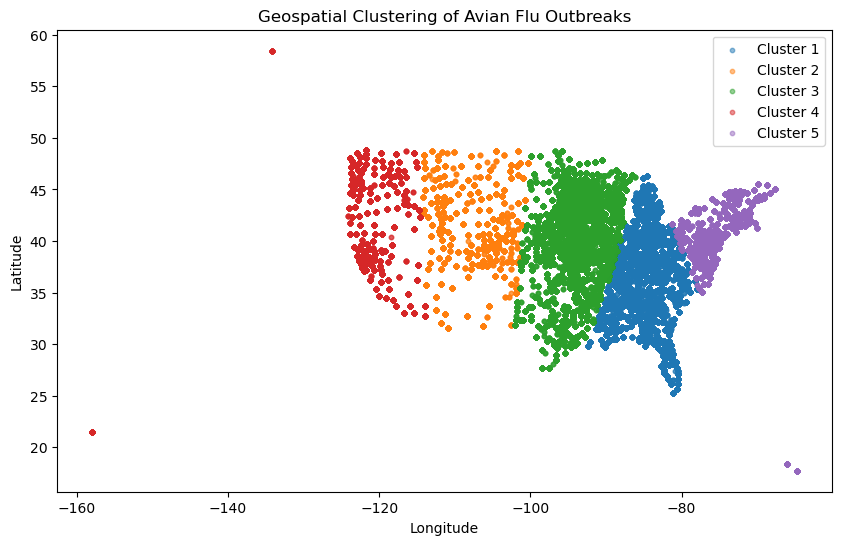

In [ ]:
# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_data = merged_df[merged_df['cluster'] == cluster]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], alpha=0.5, s=10, label=f'Cluster {cluster + 1}')
plt.title('Geospatial Clustering of Avian Flu Outbreaks')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [ ]:
# Time Series Analysis to predict future outbreaks
# Aggregate outbreaks by date
time_series = merged_df.groupby('outbreak_date').size()

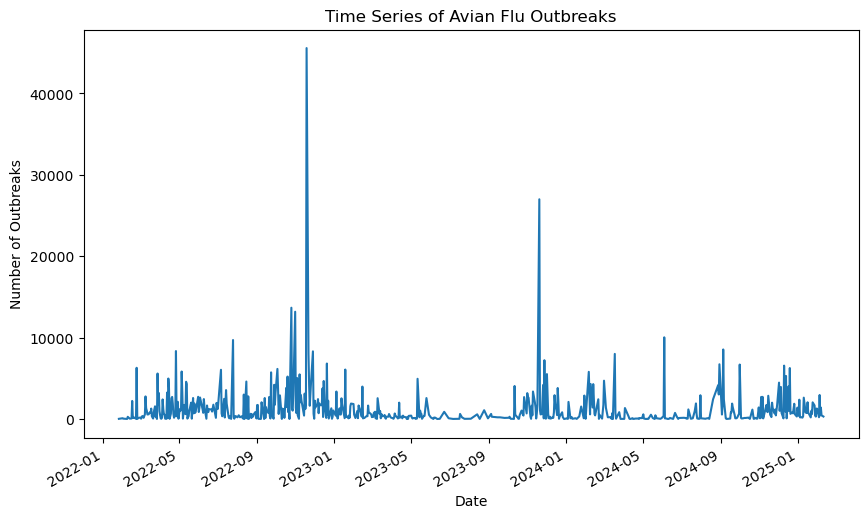

In [ ]:
# Plot time series
plt.figure(figsize=(10, 6))
time_series.plot()
plt.title('Time Series of Avian Flu Outbreaks')
plt.xlabel('Date')
plt.ylabel('Number of Outbreaks')
plt.show()

c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

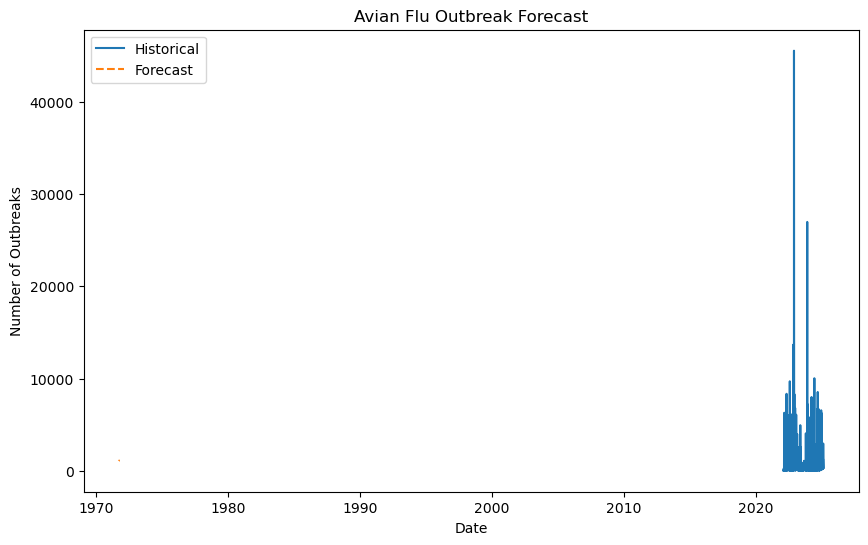

In [ ]:
# Forecasting future outbreaks using ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(time_series, order=(1, 1, 1))
model_fit = model.fit()

# Forecast next 30 days
forecast = model_fit.forecast(steps=30)

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Historical')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title('Avian Flu Outbreak Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.show()

In [ ]:
len(merged_df)

798821

In [ ]:
# OTHER ALGORITHMS BELOW

In [ ]:
# Create K-means model.

model = KMeans(n_clusters=4, n_init='auto', random_state=42)
model.fit(X_scaled_df)
kmeans_predictions = model.predict(X_scaled_df)
print(kmeans_predictions)

[0 0 0 ... 2 2 2]


In [ ]:
# Create a copy of the DataFrame
clusters_df = birdflu_data_encoded.copy()

# Add a column to the DataFrame that contains Clusters.
clusters_df['Cluster'] = kmeans_predictions

# Review the DataFrame
clusters_df.head()

,County,State,Outbreak Date,Flock Type,Species Name,Birds Affected,Flock Size,Production,Species,Production Type Name,HPAI Strain,Species_Mammals,HPAI Strain_WildBirds,Bird Species,WOAH Classification,Sampling Method,Cluster
0,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,22,2,4,0
1,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,17,2,4,0
2,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,17,2,4,0
3,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,17,2,4,0
4,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,17,2,4,0


<Axes: xlabel='Flock Size', ylabel='Sampling Method'>

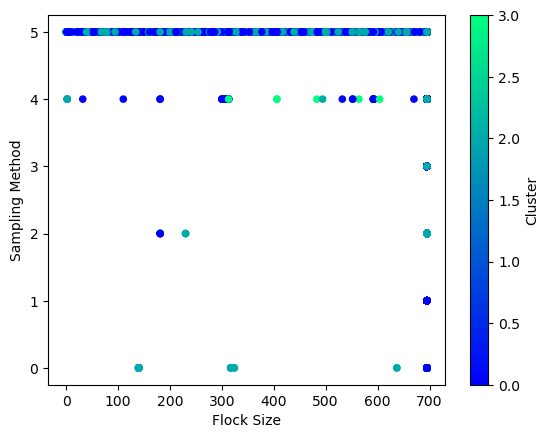

In [ ]:
# Plot the data points.

clusters_df.plot.scatter(
    x='Flock Size',
    y= 'Sampling Method',
    c='Cluster',
    colormap='winter')

In [ ]:
# Create an empty list to store the inertia values
inertia = []

# Create a list with the number of k-values to try
k = list(range(1, 11))

In [ ]:
# Create a for loop to compute the inertia with each possible value of k and add the values to the inertia list.
for i in k:
    model = KMeans(n_clusters=i, n_init=10, random_state=42)
    model.fit(clusters_df)
    inertia.append(model.inertia_)

In [ ]:
# Create a dictionary with the data to plot the elbow curve
elbow_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the elbow curve
df_elbow = pd.DataFrame(elbow_data)

# Display the DataFrame
df_elbow

,k,inertia
0,1,1.545127e+19
1,2,2.376175e+18
2,3,1.189303e+18
3,4,5.454031e+17
4,5,3.298648e+17
5,6,2.111660e+17
6,7,1.706359e+17
7,8,1.308291e+17
8,9,1.053869e+17
9,10,8.473729e+16


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

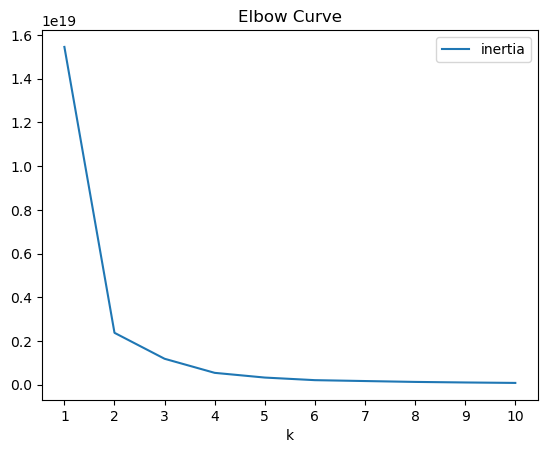

In [ ]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

In [ ]:
# Determine the rate of decrease between each k value. 
k = elbow_data["k"]
inertia = elbow_data["inertia"]
for i in range(1, len(k)):
    percentage_decrease = (inertia[i-1] - inertia[i]) / inertia[i-1] * 100
    print(f"Percentage decrease from k={k[i-1]} to k={k[i]}: {percentage_decrease:.2f}%")

Percentage decrease from k=1 to k=2: 84.62%
Percentage decrease from k=2 to k=3: 49.95%
Percentage decrease from k=3 to k=4: 54.14%
Percentage decrease from k=4 to k=5: 39.52%
Percentage decrease from k=5 to k=6: 35.98%
Percentage decrease from k=6 to k=7: 19.19%
Percentage decrease from k=7 to k=8: 23.33%
Percentage decrease from k=8 to k=9: 19.45%
Percentage decrease from k=9 to k=10: 19.59%


In [ ]:
# Fit a AgglomerativeClustering Model with five clusters
agglo_model = AgglomerativeClustering(n_clusters=5)

# Make predictions with the AgglomerativeClustering model
agglo_predictions = agglo_model.fit_predict(clusters_df)

# Previewing the predicted customer classifications for AgglomerativeClustering
agglo_predictions[-10:]

array([0, 0, 2, 0, 0, 2, 2, 4, 1, 2], dtype=int64)

In [ ]:
# Fit a Birch Model with five clusters.
birch_model = Birch(n_clusters=None)
birch_model.fit(clusters_df)

# Make predictions with the Birch model
birch_predictions = birch_model.labels_

# Previewing the predicted customer classifications for BIRCH
birch_predictions[-10:]

# Look at the results
print("\nNumber of points in each cluster:")
print(pd.Series(birch_predictions).value_counts())


Number of points in each cluster:
1815    372
1816    248
7140     82
2286     76
7508     75
       ... 
7668      1
5896      1
6577      1
6532      1
3016      1
Name: count, Length: 6677, dtype: int64


In [ ]:
# Create a copy of the preprocessed data
cluster_predictions_df = clusters_df.copy()

# Add class columns with the labels to the new DataFrame

cluster_predictions_df["kmeans-segments"] = kmeans_predictions
cluster_predictions_df["agglomerative-segments"] = agglo_predictions
cluster_predictions_df["birch-segments"] = birch_predictions
cluster_predictions_df[['kmeans-segments','agglomerative-segments', 'birch-segments']].head(3)
cluster_predictions_df.head()

,County,State,Outbreak Date,Flock Type,Species Name,Birds Affected,Flock Size,Production,Species,Production Type Name,HPAI Strain,Species_Mammals,HPAI Strain_WildBirds,Bird Species,WOAH Classification,Sampling Method,Cluster,kmeans-segments,agglomerative-segments,birch-segments
0,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,22,2,4,0,0,0,7657
1,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,17,2,4,0,0,0,7657
2,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,17,2,4,0,0,0,7657
3,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,17,2,4,0,0,0,7657
4,42,0,1677628800,16,13,0.0,695,2,3,2,3,39,10,17,2,4,0,0,0,7657


KeyError: 'Days Since First Outbreak'

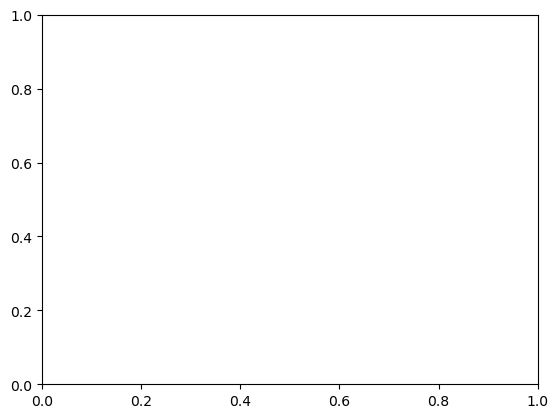

In [ ]:
# Plot the kmeans clusters. 
cluster_predictions_df.plot.scatter(
    x='Days Since First Outbreak',
    y='HPAI Strain',
    c='kmeans-segments',
    colormap='viridis')

<Axes: xlabel='Days Since First Outbreak', ylabel='HPAI Strain'>

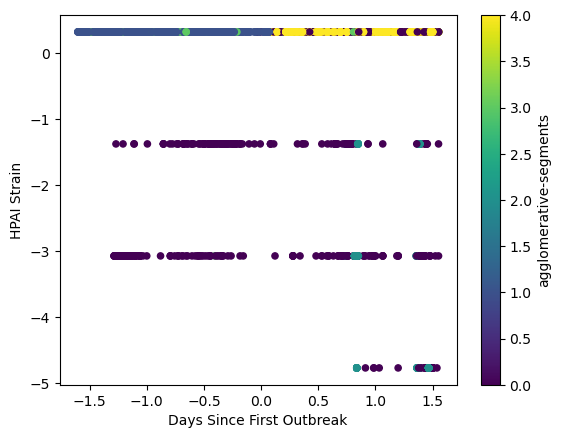

In [ ]:
# Plot the agglomerative clusters using the limit_bal and age columns. 
cluster_predictions_df.plot.scatter(
    x='Days Since First Outbreak',
    y='HPAI Strain',
    c='agglomerative-segments',
    colormap='viridis')

<Axes: xlabel='Days Since First Outbreak', ylabel='HPAI Strain'>

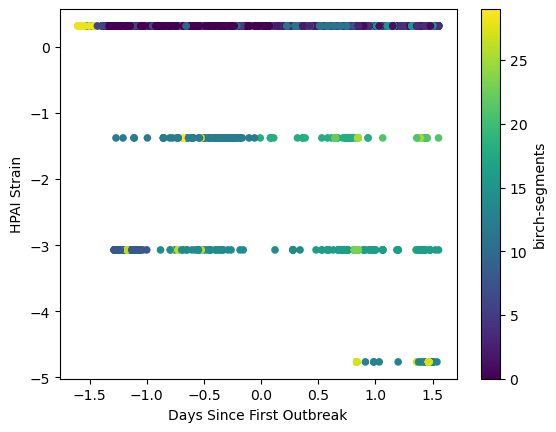

In [ ]:
# Plot the birch clusters.

cluster_predictions_df.plot.scatter(
    x='Days Since First Outbreak',
    y='HPAI Strain',
    c='birch-segments',
    colormap='viridis')

In [ ]:
# Create a list to store values and the values of k
score_kmeans = []
score_agglomerative = []
score_birch = []

# Create a list to set the range of k values to test
k = list(range(2, 11))

In [ ]:
from sklearn import metrics
# For each model, we iterate through the different cluster count (`i`). 
# Then, calculate the variance ratio for each algorithm, given that specified cluster count.

for i in k:
    # Kmeans variance and score
    k_model = KMeans(n_clusters=i, n_init='auto',random_state=0)
    k_model.fit(clusters_df)
    labels = k_model.labels_
    score = metrics.calinski_harabasz_score(clusters_df, labels)    
    score_kmeans.append(score)
    
    # AgglomerativeClustering variance and score
    agglo_model = AgglomerativeClustering(n_clusters=i)
    labels = agglo_model.fit_predict(clusters_df)
    score = metrics.calinski_harabasz_score(clusters_df, labels)    
    score_agglomerative.append(score)    
    
    # Birch variance and score
    birch_model = Birch(n_clusters=i)
    birch_model.fit(clusters_df)
    labels = birch_model.labels_
    score = metrics.calinski_harabasz_score(clusters_df, labels)    
    score_birch.append(score)

In [ ]:
# Display the scores. 
display(score_kmeans)
display(score_agglomerative)
display(score_birch)

[6183.599675907733,
 5566.470131028592,
 8393.73222715723,
 13749.370314537813,
 19993.561688829395,
 21157.520682523704,
 24958.46963000802,
 28991.5518683496,
 26528.98965034571]

[8118.722988083008,
 9671.139348128796,
 13422.501478746508,
 17514.919243747605,
 19305.78961252479,
 22277.324476090173,
 24394.36787257555,
 28079.576278372915,
 28459.37498459039]

[3793.544881203047,
 5930.09142444441,
 14816.594290784229,
 13285.507426327604,
 10794.081470894907,
 16137.359854478147,
 14221.531539224512,
 12484.734240575768,
 15191.05044117032]

In [ ]:
# Create dictionary for easy reference
dataframes = {
    "hpai-flocks": flocks_df,
    "hpai-livestock": livestock_df,
    "hpai-mammals": mammals_df,
    "hpai-wild-birds1": wild_birds_df
}

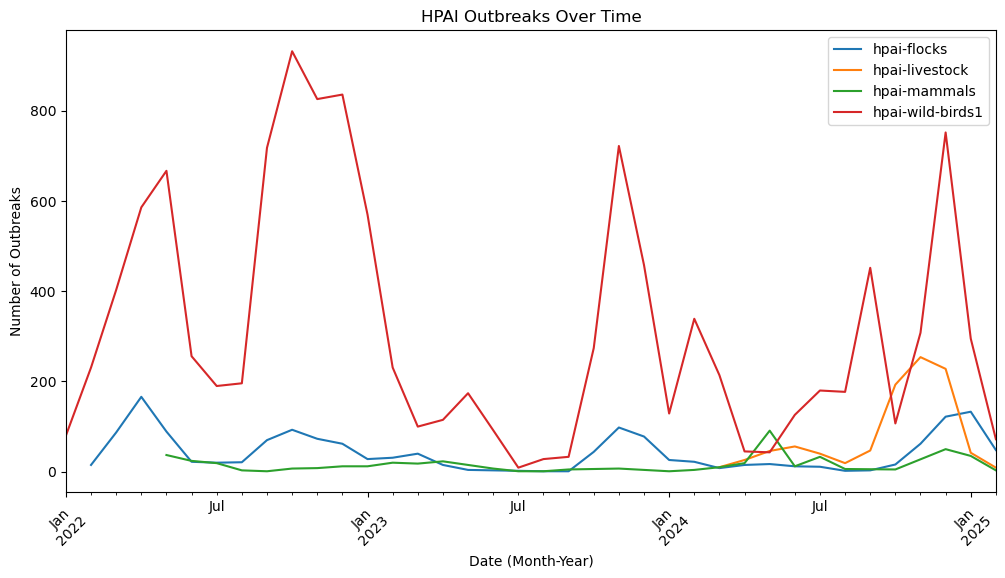

In [ ]:
# 1. HPAI Outbreaks Over Time
plt.figure(figsize=(12, 6))
for name, df in dataframes.items():
    df["Outbreak Date"].dt.to_period("M").value_counts().sort_index().plot(label=name)

plt.title("HPAI Outbreaks Over Time")
plt.xlabel("Date (Month-Year)")
plt.ylabel("Number of Outbreaks")
plt.legend()
plt.xticks(rotation=45)
plt.show()

C:\Users\mward\AppData\Local\Temp\ipykernel_19324\1280911493.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")


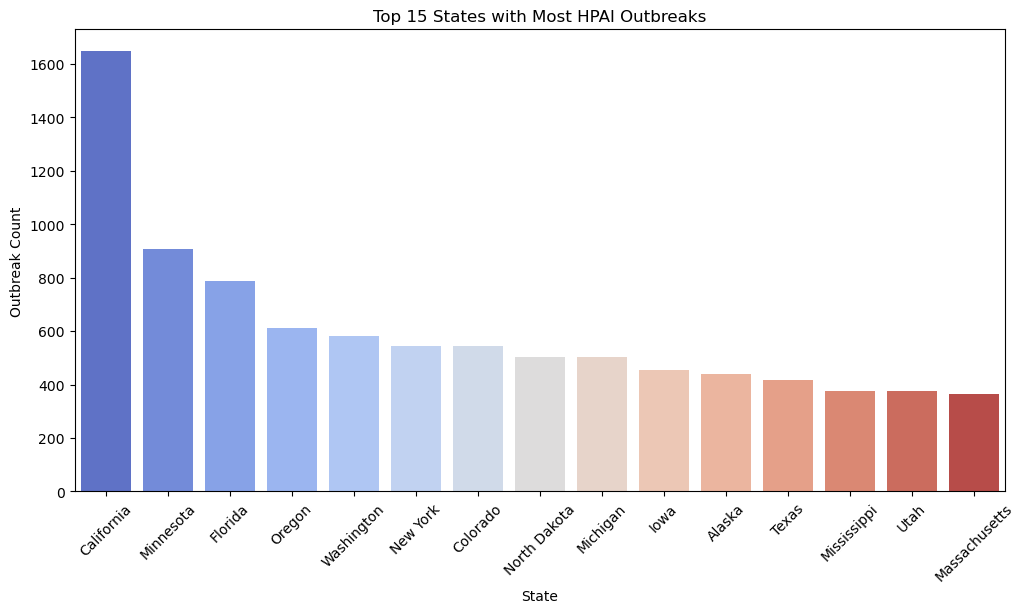

In [ ]:
# 2. Top 15 States with Most HPAI Outbreaks
plt.figure(figsize=(12, 6))
state_counts = pd.concat([df["State"] for df in dataframes.values()]).value_counts()[:15]
sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")
plt.title("Top 15 States with Most HPAI Outbreaks")
plt.xlabel("State")
plt.ylabel("Outbreak Count")
plt.xticks(rotation=45)
plt.show()

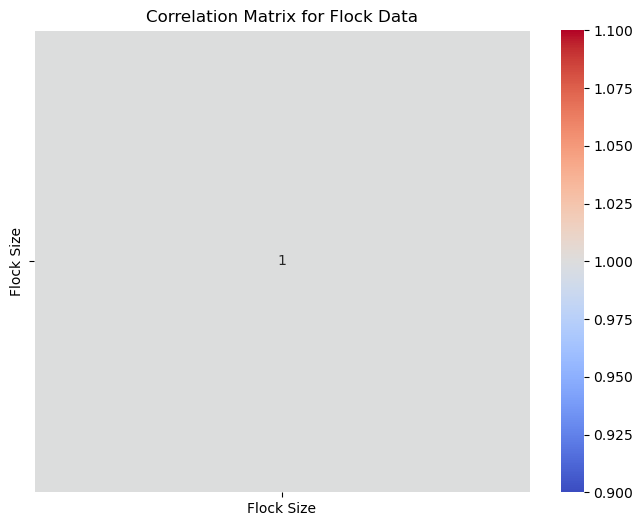

In [ ]:
# 3. Correlation Matrix for Flock Data
plt.figure(figsize=(8, 6))
sns.heatmap(flocks_df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix for Flock Data")
plt.show()

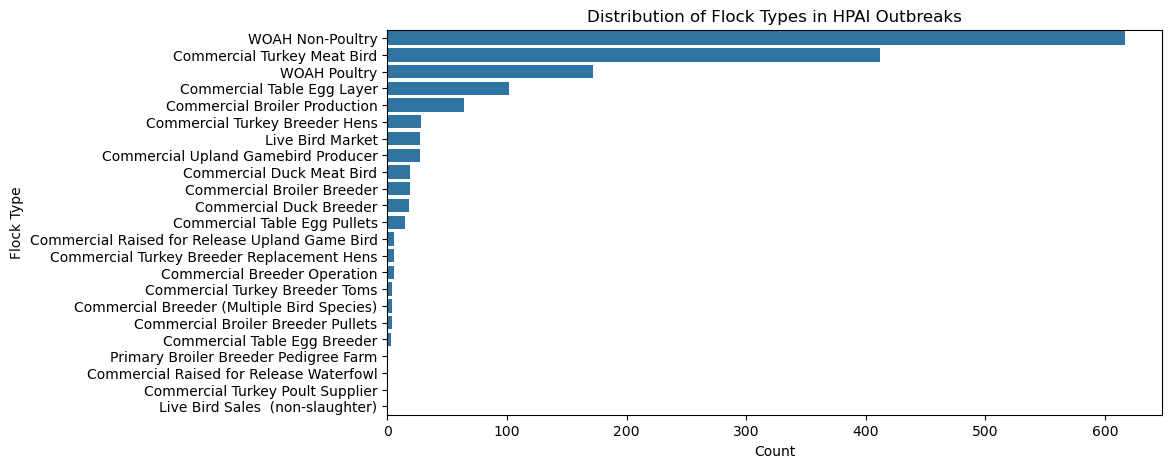

In [ ]:
# Flock Type Distribution (Only for Flocks Data)
plt.figure(figsize=(10, 5))
sns.countplot(y=dataframes["hpai-flocks"]["Flock Type"], order=dataframes["hpai-flocks"]["Flock Type"].value_counts().index)
plt.title("Distribution of Flock Types in HPAI Outbreaks")
plt.xlabel("Count")
plt.ylabel("Flock Type")
plt.show()

C:\Users\mward\AppData\Local\Temp\ipykernel_19324\2743845187.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_species.values, y=top_species.index, palette="viridis")


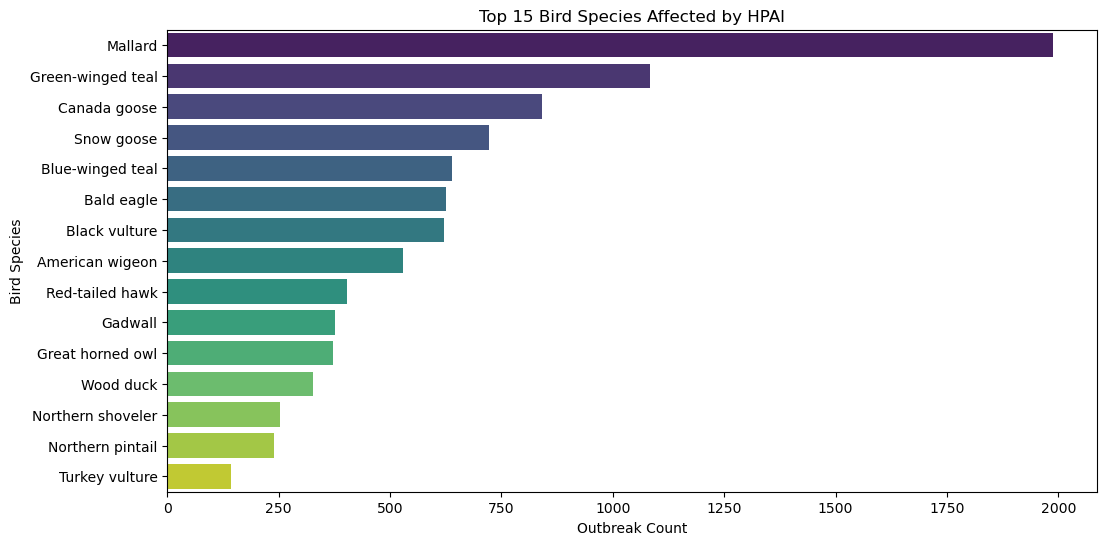

In [ ]:
# Distribution of Species Affected in Wild Birds Dataset
plt.figure(figsize=(12, 6))
top_species = dataframes["hpai-wild-birds1"]["Bird Species"].value_counts()[:15]
sns.barplot(x=top_species.values, y=top_species.index, palette="viridis")
plt.title("Top 15 Bird Species Affected by HPAI")
plt.xlabel("Outbreak Count")
plt.ylabel("Bird Species")
plt.show()

C:\Users\mward\AppData\Local\Temp\ipykernel_19324\2111612854.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=strain_counts.values, y=strain_counts.index, palette="magma")


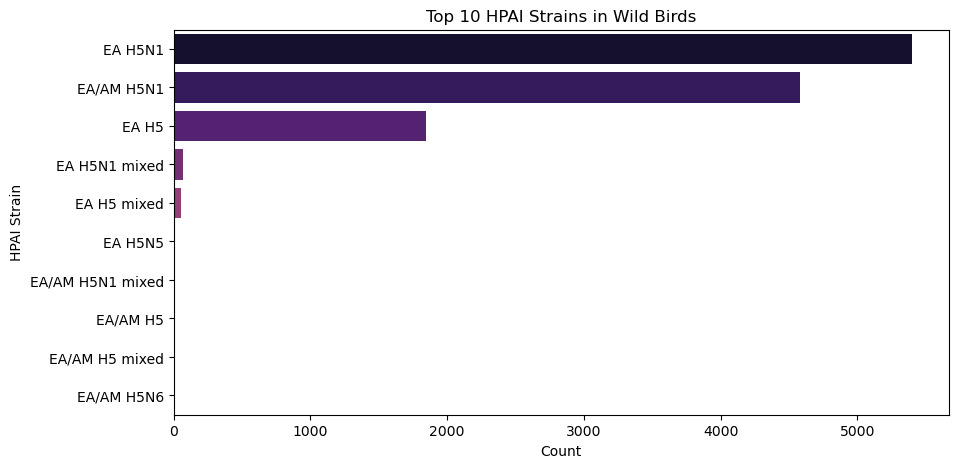

In [ ]:
# 6. HPAI Strain Frequency in Wild Birds
plt.figure(figsize=(10, 5))
strain_counts = wild_birds_df["HPAI Strain"].value_counts()[:10]
sns.barplot(x=strain_counts.values, y=strain_counts.index, palette="magma")
plt.title("Top 10 HPAI Strains in Wild Birds")
plt.xlabel("Count")
plt.ylabel("HPAI Strain")
plt.show()

C:\Users\mward\AppData\Local\Temp\ipykernel_19324\2324550223.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mammal_species_counts.values, y=mammal_species_counts.index, palette="Blues_r")


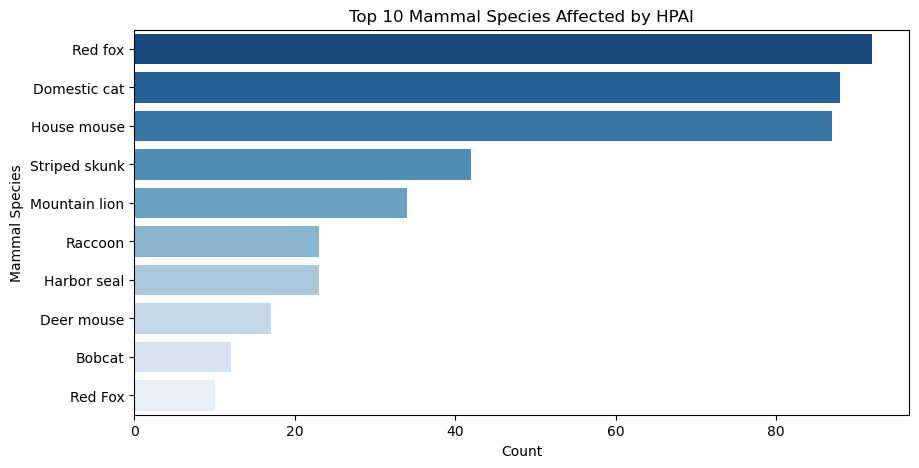

In [ ]:
# 7. Mammal Species Affected
plt.figure(figsize=(10, 5))
mammal_species_counts = mammals_df["Species"].value_counts()[:10]
sns.barplot(x=mammal_species_counts.values, y=mammal_species_counts.index, palette="Blues_r")
plt.title("Top 10 Mammal Species Affected by HPAI")
plt.xlabel("Count")
plt.ylabel("Mammal Species")
plt.show()

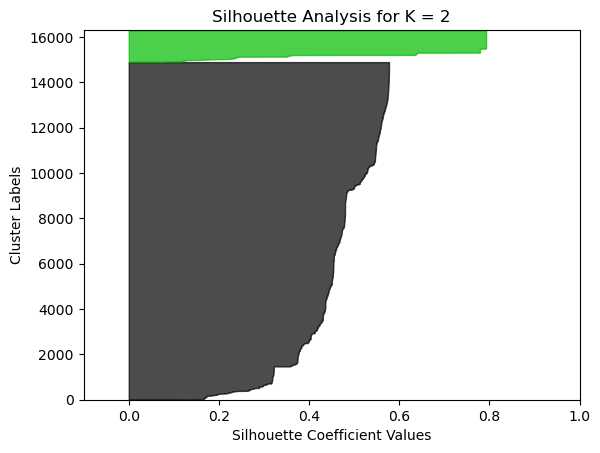

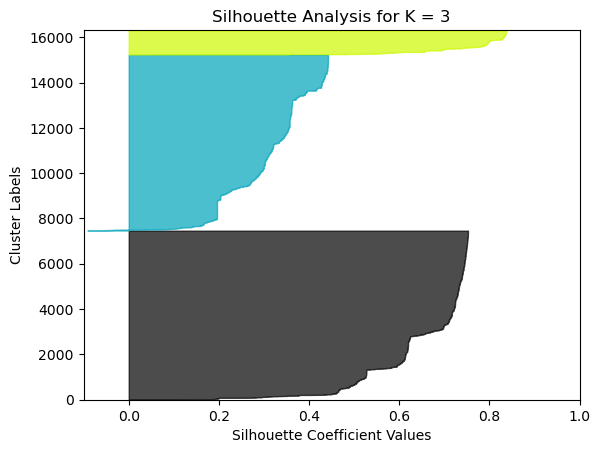

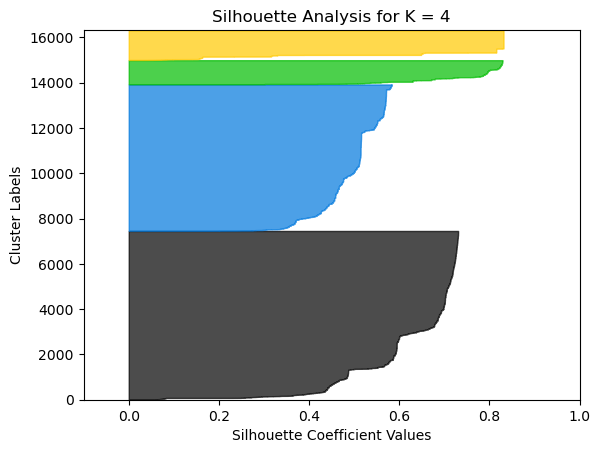

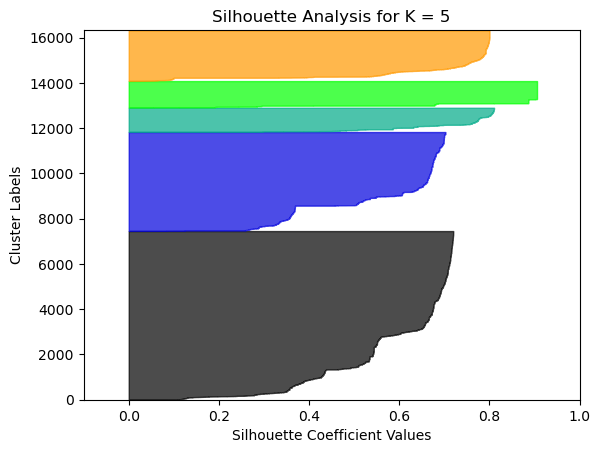

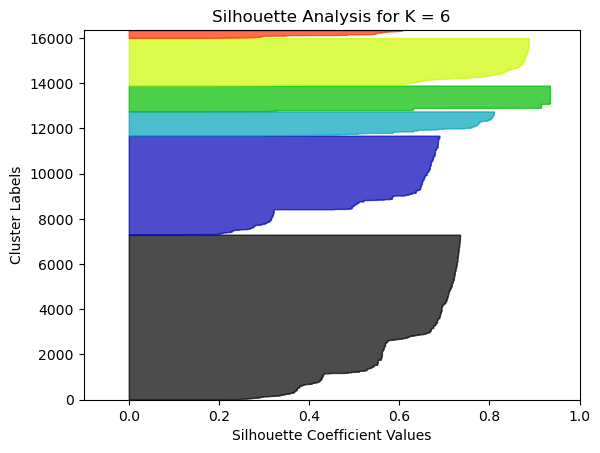

In [ ]:
# Cluster Silhouette Analysis

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(clusters_df) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(clusters_df)
    
    silhouette_avg = silhouette_score(clusters_df, cluster_labels)
    sample_silhouette_values = silhouette_samples(clusters_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        y_lower = y_upper + 10

    ax.set_title(f"Silhouette Analysis for K = {n_clusters}")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Labels")
    plt.show()


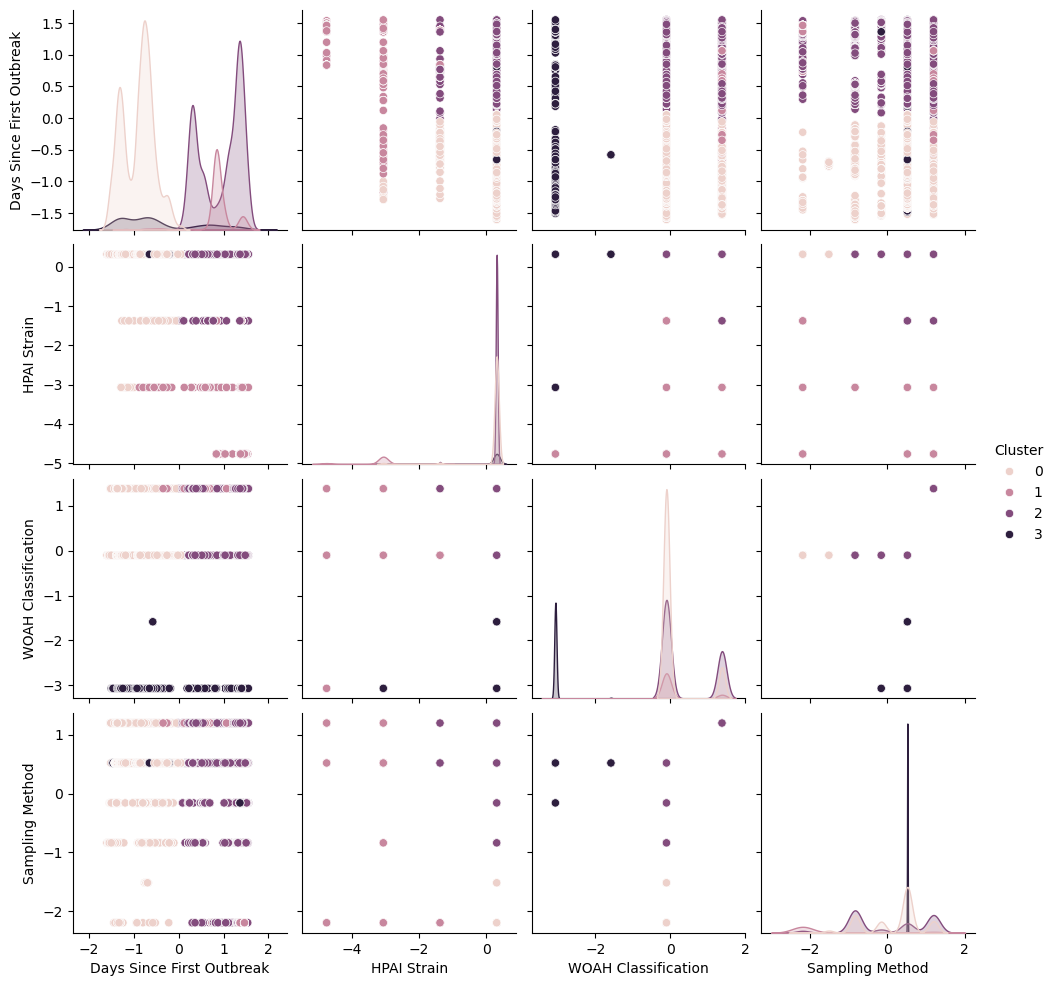

In [ ]:
# Pair Plot for Clusters

import seaborn as sns

clusters_df["Cluster"] = kmeans_predictions  # Assign cluster labels
sns.pairplot(clusters_df, hue="Cluster", diag_kind="kde")
plt.show()


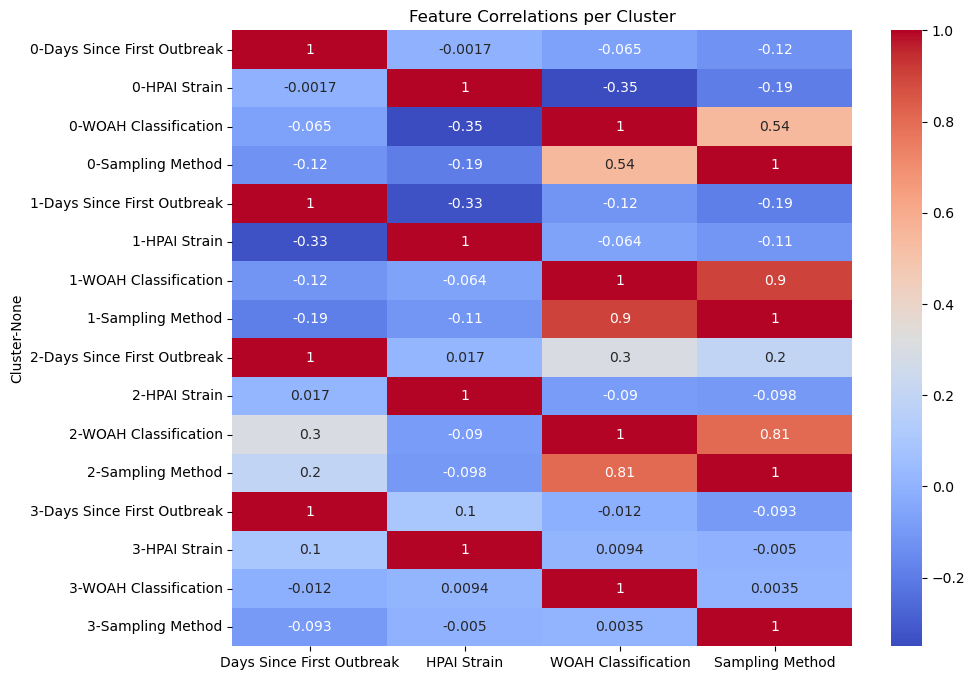

In [ ]:
# Heatmap of Feature Correlations by Cluster

cluster_corrs = clusters_df.groupby("Cluster").corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_corrs, cmap="coolwarm", annot=True)
plt.title("Feature Correlations per Cluster")
plt.show()
